<h2> appendix

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances,accuracy_score
from sklearn.cluster import AgglomerativeClustering,KMeans
from scipy.spatial.distance import squareform, pdist
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_classification , make_circles,make_s_curve
import mpl_toolkits.mplot3d 
from scipy.spatial import distance


In [2]:
def evaluate_accuracy(predictions,labels):
    accuracy = accuracy_score(labels, predictions)
    return accuracy*100

In [3]:
def gauss_mle_fit_case1(D, sigma, p, initial_type):
    N = D.shape[1]
    k = len(sigma)

    # Initial condition
    if initial_type is None or initial_type == 'rand':
        mu0 = np.random.rand(k, N)
    elif initial_type == 'kmeans':
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(D)
        mu0 = kmeans.cluster_centers_

    delta = 1
    mu = np.zeros_like(mu0)
    p_xk = np.zeros((D.shape[0], k))  # Initialize p_xk

    while delta > 1e-2:
        # MLE Calculation
        for i in range(k):
            gm = multivariate_normal(mu0[i], sigma[i])  # Use 2D covariance matrix for each cluster
            p_xk[:, i] = gm.pdf(D)

        p_wi = (p_xk * p) / np.sum(p_xk * p, axis=1, keepdims=True)

        for i in range(k):
            mu[i] = np.sum(p_wi[:, i, np.newaxis] * D, axis=0) / np.sum(p_wi[:, i])

        # Evaluate
        delta = np.linalg.norm(mu - mu0)
        mu0 = mu.copy()


    return mu

In [4]:
def gauss_mle_cluster_case1(D,labels, sigma, p,initial_type):
    best_accuracy = 0.0
    best_pred = None
    for i in range(100):
        mu = gauss_mle_fit_case1(D, sigma, p,initial_type)
        k = mu.shape[0]
        p_xk = np.zeros((D.shape[0], k))  # Initialize p_xk

        # MLE Calculation
        for i in range(k):
            gm = multivariate_normal(mu[i], sigma[i])  # Use 2D covariance matrix for each cluster
            p_xk[:, i] = gm.pdf(D)

        # Cluster
        predictions = np.argmax(p_xk, axis=1)
        accuracy = evaluate_accuracy(predictions, labels)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_pred=predictions
            

    return best_pred, best_accuracy

In [5]:
def gauss_mle_cluster_case2(D, sigma, p, initial_type):
    N = D.shape[1]
    k = len(sigma)

    # Initial condition
    if initial_type is None or initial_type == 'rand':
        mu0 = np.random.rand(k, N)
    elif initial_type == 'kmeans':
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(D)
        mu0 = kmeans.cluster_centers_

    delta = 1
    mu = np.zeros_like(mu0)
    p_xk = np.zeros((D.shape[0], k))  # Initialize p_xk

    while delta > 1e-2:
        # MLE Calculation
        for i in range(k):
            gm = multivariate_normal(mu0[i], sigma[i])  # Use 2D covariance matrix for each cluster
            p_xk[:, i] = gm.pdf(D)

        p_wi = (p_xk * p) / np.sum(p_xk * p, axis=1, keepdims=True)

        for i in range(k):
            mu[i] = np.sum(p_wi[:, i, np.newaxis] * D, axis=0) / np.sum(p_wi[:, i])

        # Evaluate
        delta = np.linalg.norm(mu - mu0)
        mu0 = mu.copy()

    # Cluster
    predictions = np.argmax(p_xk, axis=1)

    return predictions

In [6]:
def get_distance_2d(cluster_1, cluster_2, distance_metric="euclidean"):
    """Gets the distance between the two given 2D clusters.

    Args:
      cluster_1: A list of 2D data points.
      cluster_2: A list of 2D data points.
      distance_metric: The distance metric to use. Can be "euclidean" or "manhattan".

    Returns:
      The distance between the two clusters.
    """
    sum=0
    for data_point1 in cluster_1:
        for data_point_2 in cluster_2:

            if distance_metric == "euclidean":
                sum=sum+(data_point1-data_point_2)**2
            elif distance_metric == "manhattan":
                sum=sum+abs(data_point1-data_point_2)
    if distance_metric == "euclidean":
        sum=math.sqrt(sum)
    return sum

In [7]:
def find_closest_clusters_2d(clusters, distance_metric="euclidean"):
    """Finds the two closest clusters in the given list of 2D clusters.

    Args:
      clusters: A list of lists, where each inner list represents a 2D cluster.
      distance_metric: The distance metric to use. Can be "euclidean" or "manhattan".

    Returns:
      A list of two lists, where the first list is the first cluster and the second
      list is the second cluster.
    """

    closest_clusters = []
    closest_distance = float("inf")

    for cluster_1 in clusters:
        for cluster_2 in clusters:
            if cluster_1 [1] == cluster_2[1] and cluster_1 [0] == cluster_2[0]:
                continue

            dist = distance.euclidean(cluster_1, cluster_2)
            if dist < closest_distance:
                closest_distance = dist
                closest_clusters = [cluster_1, cluster_2]

    return closest_clusters



In [8]:
def agg_clustering_case1(data, distance_metric="euclidean"):
  """Performs agglomerative hierarchical clustering on the given data.

  Args:
    data: A list of lists, where each inner list represents a data point.
    distance_metric: The distance metric to use. Can be "euclidean" or "manhattan".

  Returns:
    A list of lists, where each inner list represents a cluster.
  """
  clusters = []
  for data_point in data:
      clusters.append(data_point)

  while len(clusters) > 1:
      closest_clusters = find_closest_clusters_2d(clusters, distance_metric)
      cluster_1, cluster_2 = closest_clusters

      new_cluster = cluster_1 + cluster_2
      new_cluster_list=[]
      for x in clusters :
         if (x[0]!=cluster_1[0] and x[1]!=cluster_1[1]) or (x[0]!=cluster_2[0] and x[1]!=cluster_2[1]):
            new_cluster_list.append(x)

      new_cluster_list.append(new_cluster)
      clusters=new_cluster_list

  return clusters

In [9]:
#agg optimal cluster via sklearn
def agg_optimal_clustering_case1(D,labels, K):
    # Create an instance of AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')

    # Fit the model to your data
    clustering.fit(D)

    # Obtain the predicted labels
    predictions = clustering.labels_
    print(predictions)
    acuracy = evaluate_accuracy(predictions, labels)
    return predictions, acuracy
def agg_optimal_clustering_case2(D, K):
    # Create an instance of AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')

    # Fit the model to your data
    clustering.fit(D)

    # Obtain the predicted labels
    predictions = clustering.labels_
    print(predictions)

    return predictions

In [10]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, labels):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    scatter=ax.scatter(x, y, s=40, c=labels, edgecolor='k')
    ax.set_aspect(1.)
    
    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)

    unique_labels = np.unique(labels)
    array_length = len(unique_labels)
    x1 = [[] if i == 0 else [] for i in range(array_length)]
    y1 = [[] if i == 0 else [] for i in range(array_length)]
    for i in range(len(labels)):
        for l in range(len(unique_labels)):
            if unique_labels[l] == labels[i]:
                x1[l].append(x[i])
                y1[l].append(y[i])
    legend_handles = []
    for label in range(len(unique_labels)):
        legend_handles.append(scatter.legend_elements()[0][label])
    ax.legend(legend_handles, unique_labels, title='Labels')

    # Plot KDE curves
    # Plot histograms
    for i in range(len(unique_labels)):
        ax_histx.hist(x1[i], bins=bins, color=scatter.cmap(scatter.norm(unique_labels[i])),edgecolor='k')
        ax_histy.hist(y1[i], bins=bins, orientation='horizontal', color=scatter.cmap(scatter.norm(unique_labels[i])),edgecolor='k')

        # Plot KDE curves
       # sns.kdeplot(x1[i], ax=ax_histx, color=scatter.cmap(scatter.norm(unique_labels[i])))
      #  sns.kdeplot(y1[i], ax=ax_histy, color=scatter.cmap(scatter.norm(unique_labels[i])))

        # Compute mean and variance
        x_mean = np.mean(x1[i])
        x_var = np.var(x1[i])
        y_mean = np.mean(y1[i])
        y_var = np.var(y1[i])

    # Annotate mean and variance
    ax_histx.text(-3, -2, f"Mean: {x_mean:.2f}\nVar: {x_var:.2f}", ha='center', va='bottom', color='red',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    ax_histy.text(-1, -4, f"Mean: {y_mean:.2f}\nVar: {y_var:.2f}", ha='left', va='center', color='red',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

    #ax_histx.hist(x, bins=bins)
    #ax_histy.hist(y, bins=bins, orientation='horizontal')

    # Set labels for components
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Set labels for histograms
    ax_histx.set_ylabel('Probability Density')
    ax_histy.set_xlabel('Probability Density')
    

In [11]:
def scatter_plt(data, pred, accuracy,headline):
    # Start with a square Figure.
    fig = plt.figure(figsize=(6, 6))
    # Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
    # the size of the marginal axes and the main axes in both directions.
    # Also adjust the subplot parameters for a square plot.
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    # Draw the scatter plot and marginals.
    scatter_hist(data[:,0], data[:,1], ax, ax_histx, ax_histy, pred)
    if accuracy!=-1:
        ax.text(-1,-1, f"accuracy: {accuracy:.2f}", ha='left', va='center', color='red',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    fig.suptitle(headline)
    plt.show()


<h2>2D gaussian data with one center

In [12]:

sigma = [[[1, 0], [0, 1]], [[1, 0], [0, 1]]]  # Covariance matrices for each component
p = [0.5, 0.5]  # Probabilities for each component


mle estimation using random initialization:

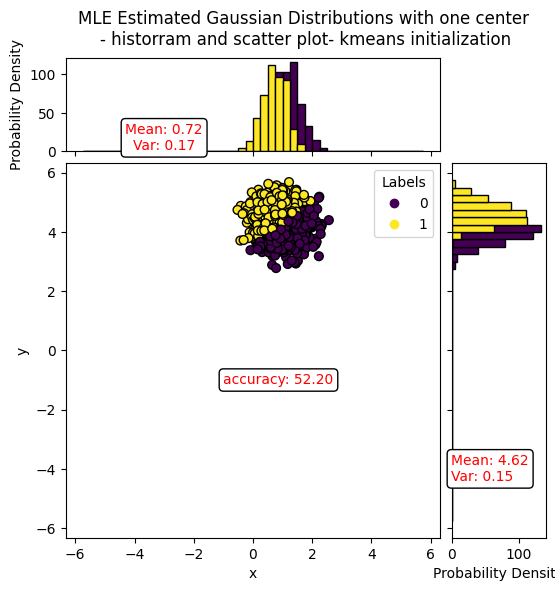

In [13]:
data, labels = make_blobs(n_samples=1000, centers=1, cluster_std=0.5, random_state=0, n_features=2)
pred1, accuracy1=gauss_mle_cluster_case1(data, labels, sigma, p, initial_type='rand')
scatter_plt(data, pred1, accuracy1,
                                    'MLE Estimated Gaussian Distributions with one center \n- historram and scatter plot- kmeans initialization')
    

 mle estimation using kmean initialization:

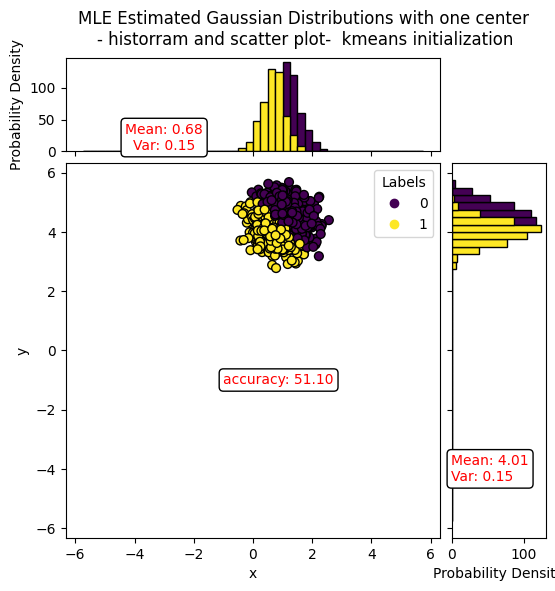

In [14]:
pred2, accuracy2 = gauss_mle_cluster_case1(data, labels, sigma, p, initial_type='kmeans')
scatter_plt(data, pred2, accuracy2,
                                    'MLE Estimated Gaussian Distributions with one center \n- historram and scatter plot-  kmeans initialization')
    

In [15]:
pred3, accuracy3 = agg_clustering_case1(data,"euclidean")
scatter_plt(data, pred3, accuracy3,
                                    'agg Estimated Gaussian Distributions with one center \n- historram and scatter plot-  distance type min')


KeyboardInterrupt: 